### 🚀 For an interactive experience, head over to our [demo platform](https://var.vision/demo) and dive right in! 🌟

In [1]:
################## 1. Download checkpoints and build models
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageShow as PImageShow

from models import build_vae_var

setattr(torch.nn.Linear, 'reset_parameters', lambda _: None)     # disable default parameter init for faster speed
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda _: None)  # disable default parameter init for faster speed

MODEL_DEPTH = 16
assert MODEL_DEPTH in {16, 20, 24, 30}

# download checkpoint
hf_home = 'https://huggingface.co/FoundationVision/var/resolve/main'
vae_ckpt, var_ckpt = f'vae_ch160v4096z32_d{MODEL_DEPTH}.pth', f'var_d{MODEL_DEPTH}.pth'

if not osp.exists(vae_ckpt):
    vae_ckpt_old = vae_ckpt.replace(f"_d{MODEL_DEPTH}", "")
    os.system(f'wget {hf_home}/{vae_ckpt_old}')
    os.rename(vae_ckpt_old, vae_ckpt)
if not osp.exists(var_ckpt):
    os.system(f'wget {hf_home}/{var_ckpt}')

# build vae, var
patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if 'vae' not in globals() or 'var' not in globals():
    vae, var = build_vae_var(
        V=4096, Cvae=32, ch=160, share_quant_resi=4,    # hard-coded VQVAE hyperparameters
        device=device, patch_nums=patch_nums,
        num_classes=1000, depth=MODEL_DEPTH, shared_aln=False,
    )

# load checkpoints
vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
var.load_state_dict(torch.load(var_ckpt, map_location='cpu'), strict=True)
vae.eval(), var.eval()
for p in vae.parameters(): p.requires_grad_(False)
for p in var.parameters(): p.requires_grad_(False)
print(f'prepare finished.')


[constructor]  ==== flash_if_available=True (16/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422
prepare finished.


In [2]:
############################# 2. Sample with classifier-free guidance
import random as rand
import ipywidgets as widgets
import matplotlib.pyplot as plt

%matplotlib inline

# set args
seed = 0
torch.manual_seed(seed)
batch_size = 8
# class_labels = (980, 980, 437, 437, 22, 22, 562, 562)  #@param {type:"raw"}
class_labels = (980,) * 8
# class_labels = [rand.randint(0, 999) for _ in range(batch_size)]

# seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# run faster
tf32 = True
torch.backends.cudnn.allow_tf32 = bool(tf32)
torch.backends.cuda.matmul.allow_tf32 = bool(tf32)
torch.set_float32_matmul_precision('high' if tf32 else 'highest')

# sample
label_B: torch.LongTensor = torch.tensor(class_labels, device=device)

In [3]:
from imagenet1000_classes import IMAGENET1K_CLASSES # for human-friendly class names

def sample(cfg: float, more_smooth: bool):
    fig, ax = plt.subplots(nrows=1, ncols=batch_size, figsize=(20, 20))
    with torch.inference_mode():
        with torch.autocast('cuda', enabled=True, dtype=torch.float16, cache_enabled=True): # using bfloat16 can be faster
            recon_B3HW = var.autoregressive_infer_cfg(
                B=batch_size,
                label_B=label_B,
                cfg=cfg,
                top_k=900,
                top_p=0.95,
                g_seed=seed,
                more_smooth=more_smooth
            )
    for j in range(batch_size):
        ax[j].axis("off")
        ax[j].imshow(recon_B3HW[j].cpu().float().permute(1, 2, 0))
    plt.subplots_adjust(hspace=0., wspace=0.)
    plt.savefig(f"../figures/{IMAGENET1K_CLASSES[class_labels[0]]}_cfg_new.svg", transparent=True)
    plt.show()

# slider = widgets.FloatSlider(value=0., min=-1., max=50., step=.1, description="CFG")
# check = widgets.Checkbox(value=False, description="Smoothen")

# widgets.interactive(sample, cfg=slider, more_smooth=check)

cond_BD.shape = torch.Size([16, 1024])
self.lvl_embed.weight.data.shape = torch.Size([10, 1024]), self.lvl_1L.shape = torch.Size([1, 680]), self.pos_1LC.shape = torch.Size([1, 680, 1024])
w_ll.shape = torch.Size([1, 1]), logits_BlV.shape[1:] = torch.Size([1, 4096])
w_ll.shape = torch.Size([4, 4]), logits_BlV.shape[1:] = torch.Size([4, 4096])
w_ll.shape = torch.Size([9, 9]), logits_BlV.shape[1:] = torch.Size([9, 4096])
w_ll.shape = torch.Size([16, 16]), logits_BlV.shape[1:] = torch.Size([16, 4096])
w_ll.shape = torch.Size([25, 25]), logits_BlV.shape[1:] = torch.Size([25, 4096])
w_ll.shape = torch.Size([36, 36]), logits_BlV.shape[1:] = torch.Size([36, 4096])
w_ll.shape = torch.Size([64, 64]), logits_BlV.shape[1:] = torch.Size([64, 4096])
w_ll.shape = torch.Size([100, 100]), logits_BlV.shape[1:] = torch.Size([100, 4096])
w_ll.shape = torch.Size([169, 169]), logits_BlV.shape[1:] = torch.Size([169, 4096])
w_ll.shape = torch.Size([256, 256]), logits_BlV.shape[1:] = torch.Size([256, 4096])


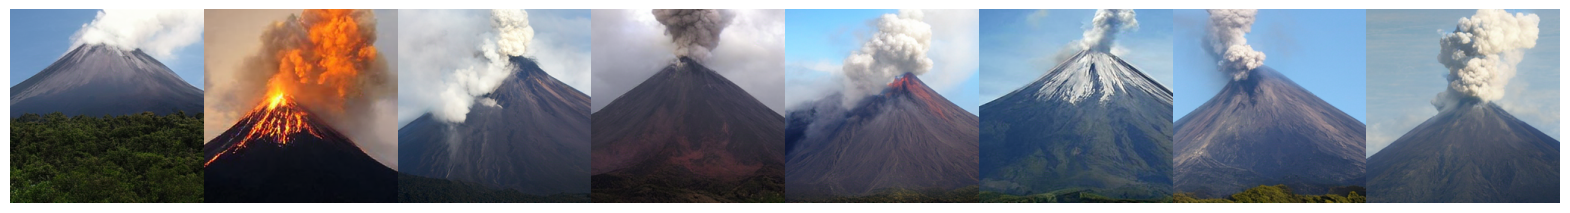

In [4]:
sample(cfg=4., more_smooth=False)